# Lecture 7: Active learning. Learning hyperparameters for GP. <br> Global and local sensitivity analysis, Sobol' indices, PC-based Sobol' indices

## How to explore the function of interest via GP process?

### Bayesian optimization
1. **for** $t=1,2,\ldots$
2. Find $\mathbf{x}_t$ by combining attributes of the posterior distribution in a utility function and maximizing: $x_t = \text{argmax}_\mathbf{x} u(\mathbf{x}~|~\mathcal{D}_{1:t-1})$.
3. Sample the objective $y_t = f(\mathbf{x}_t) + \epsilon_t$.
4. Augment the data $\mathcal{D_{1:t} = \{D_{1:t-1},(\mathbf{x}_t,y_t)\}}$ and update the GP.
5. **end for**

### Exploration-exploitation trade-off

* we should choose the next input $\mathbf{x}$ where the mean is high (exploitation) and the variance is high (exploration) as well (the simplest utility function is $\mu(\mathbf{x})+\alpha\dot\sigma(\mathbf{x})$)
* this can be accounted in the acquisition (or utility) function 
* if we need to explore (not find the max of min) the function of interest, then the utility function is just a value of standard deviation $u(x~|~\mathcal{D}_{1:t-1}) = \sigma(\mathbf{x})$ 
* popular acquisition functions: probability of improvement, expected improvement, GP-UCB, Thompson  

In the example below, we explore the function of interest 
$$
f(x)=\frac12\cos(2x)+\sin(0.9x)
$$
with the use of GPR for two sampling approaches: random and adaptive with maximization of s.d. as a utility function. Also, approximation error is considered and compared.

In the demo below, we can change 4 parameters, $\ell$ is the correlation length, $N$ and $n$ are the number of training and test points, correspondingly, $\sigma$ is the amount of noise at each point.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
from ipywidgets import interactive, interact, widgets
import scipy.spatial as SP

from scipy.stats import norm


def GP(length_scale, n, N, sigma, mode):
    # mode: if 0 -- active learning, if 1 -- random selection
    np.random.seed(42)

    Xtest = np.linspace(-5, 5, n)[:, None]

    def f(x): return 0.5*np.cos(2*x.flatten())+np.sin(0.9*x.flatten())

    def kernel(a, b):
        return np.exp(-.5 * SP.distance.cdist(a, b, 'sqeuclidean')/(length_scale**2))

    def fitting(X, num_of_points):
        y  = f(X) + sigma*np.random.randn(num_of_points)
        K  = kernel(X, X)
        L  = np.linalg.cholesky(K + sigma*np.eye(num_of_points))
        Lk = np.linalg.solve(L, kernel(X, Xtest))
        mu = np.dot(Lk.T, np.linalg.solve(L, y))
        K_ = kernel(Xtest, Xtest)
        s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
        s  = np.sqrt(s2)
        return y, mu, s

    err_act = []
    err_rand = []

    for t in range(1, N+1):
        mu_act = 0
        if t == 1:
            X_act = np.random.uniform(-5, 5, size=(1, 1))
            _, _, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(np.array(s_act))]).reshape(t+1, 1)
        else:
            y_act, mu_act, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(np.array(s_act))]).reshape(t+1, 1)
        X_act = X_act[:N]
        err_act.append(np.linalg.norm(f(Xtest)-mu_act, ord=np.inf) /
                       np.linalg.norm(f(Xtest), ord=np.inf))

    X_rand = np.random.uniform(-5, 5, size=(N, 1))
    y_rand, mu_rand, s_rand = fitting(X_rand, N)
    for t in range(1, N+1):
        mu_rand = 0
        X_rand_t = np.copy(X_rand[:t])
        _, mu_rand, _ = fitting(X_rand_t, t)
        err_rand.append(np.linalg.norm(f(Xtest)-mu_rand,
                                       ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    if mode == 'Adaptive sampling':
        y = y_act
        X = X_act
        mu = mu_act
        s = s_act
    else:
        y = y_rand
        X = X_rand
        mu = mu_rand
        s = s_rand

    plt.figure(1, figsize=(9, 7))
    plt.clf()
    plt.plot(X, y, 'r+', ms=18, label="Training points")
    plt.plot(Xtest, f(Xtest), 'b-', label="Function")
    plt.fill_between(Xtest.flat, mu-s, mu+s, color="#dddddd",
                     label="Confidence interval")
    plt.plot(Xtest, mu, 'r--', lw=2, label="Approximation")
    plt.fill_between(Xtest.flat, s-3., -3*np.ones(len(Xtest)),
                     color="green", alpha=0.1)
    plt.plot(Xtest.flat, s-3., 'g-', lw=2, label="Acquisition function")
    plt.title("Error (inf. norm) = " + str(round(np.linalg.norm(f(Xtest)-mu, ord=np.inf) /
                                                 np.linalg.norm(f(Xtest), ord=np.inf), 4)))  # (r'Mean prediction plus-minus one s.d.')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.axis([-5, 5, -3, 3])
    plt.legend()
    #print("Error (inf. norm) = ", np.linalg.norm(f(Xtest)-mu, ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.plot(range(1, N+1), err_rand, label="Random Choice")
    plt.plot(range(1, N+1), err_act, label="Active Learning")
    plt.xlabel('$N$ number of training points', fontsize=12)
    plt.ylabel('$\epsilon$ approxiamtion error', fontsize=12)
    plt.axis([1, N+0.5, 0.001, 1.1])
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()


controls = {r'sigma': widgets.FloatSlider(min=5e-4, max=5e-1, step=1e-3, value=1e-3, continuous_update=True, description=r'$\sigma$'),
            r'length_scale': widgets.FloatSlider(min=0.1, max=2.0, step=0.05, value=0.7, continuous_update=True, description=r'$\ell$'),
            r'N': widgets.IntSlider(min=1, max=50, step=1, value=5, continuous_update=True, description=r'$N$'),
            r'n': widgets.IntSlider(min=1, max=100, step=1, value=50, continuous_update=True, description=r'$n$'),
            r'mode': widgets.RadioButtons(options=['Adaptive sampling', 'Random sampling'], value='Adaptive sampling', description='Sampling:', disabled=False)}

In [2]:
interact(GP, **controls);  

interactive(children=(FloatSlider(value=0.7, description='$\\ell$', max=2.0, min=0.1, step=0.05), IntSlider(value=50, description='$n$', min=1), IntSlider(value=5, description='$N$', max=50, min=1), FloatSlider(value=0.001, description='$\\sigma$', max=0.5, min=0.0005, step=0.001), RadioButtons(description='Sampling:', options=('Adaptive sampling', 'Random sampling'), value='Adaptive sampling'), Output()), _dom_classes=('widget-interact',))

## How to learn hyperparameters of GP model?

* The parameters of the kernel can be found by using maximum marginal likelihood (in the case of SE kernel, $\theta = \ell$):
$$ 
p(\mathbf{y}~|~\mathbf{X},\mathbf{\theta}) = \int p(\mathbf{y}~|~\mathbf{f},\mathbf{X})p(\mathbf{f}~|~\mathbf{X})d\mathbf{f}\\
p(\mathbf{f}~|~\mathbf{X},\mathbf{\theta}) = \mathcal{N}(\mathbf{f}~|~\mathbf{0},\mathbf{K})\\
p(\mathbf{y}~|~\mathbf{f},\mathbf{\theta}) = \prod_i\mathcal{N}(y_i~|~f_i,\sigma_y^2)
$$

Logarithm of it:
$$
\log p(\mathbf{y}~|~\mathbf{X},\mathbf{\theta}) = \log\mathcal{N}(\mathbf{y}~|~\mathbf{0},\mathbf{K}_y) = -\frac{1}{2}\mathbf{y}\mathbf{K}^{-1}_y\mathbf{y} - \frac{1}{2}\log|\mathbf{K}_y| - \frac{N}{2}\log(2\pi)\\
\frac{\partial}{\partial\theta_j}\log p(\mathbf{y}~|~\mathbf{X},\mathbf{\theta}) = \frac{1}{2}\mathbf{y}^T\mathbf{K}^{-1}_y\frac{\partial\mathbf{K}_y}{\partial\theta_j}\mathbf{K}^{-1}_y\mathbf{y} - \frac{1}{2}\text{tr}\left(\mathbf{K}^{-1}_y\frac{\partial\mathbf{K}_y}{\partial\theta_j}\right) 
$$


In the example below, we will see the result of finding GP model parameters with the use of maximum likelihood. 
As a function that we approximate, we take 
$$
f(x)=-\cos(\pi x)+\sin(3\pi x)
$$
with addition of noise with deviation $0.1$.

In manual mode one can try to match the parameters (```var``` and $\ell$ are parameter of the Gaussian kernel, $\sigma$ is noise value) to reduce the error.  In optimized mode they are calculated automatically.
We use Python package ```GPy``` for all internal optimization, information about his work is shown in the table below.

In [3]:
def GP_opt(variance, l, s, mode):
    np.random.seed(4)
    X = np.linspace(0.05, 0.95, 10)[:, None]
    Y = -np.cos(np.pi*X) + np.sin(3*np.pi*X) + \
        np.random.normal(loc=0.0, scale=0.1, size=(10, 1))
    k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=l)
    m = GPy.models.GPRegression(X, Y, k)
    m.Gaussian_noise = s
    plt.clf()
    m.constrain_positive()
    if mode == 'Optimized':
        m.optimize('lbfgs')
    m.plot()
    print(m)
    print("Likelihood = ", m.log_likelihood())

w_variance = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'var')
w_l = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'$\ell$')
w_s = widgets.FloatSlider(min=1e-3, max=1e-1, step=1e-2, value=1., continuous_update=True, description=r'σ')
w_mode = widgets.RadioButtons(options=['Optimized', 'Manual'], value='Manual', description='Tuning:', disabled=False)
def update_mode(*args):
    for w in [w_variance, w_l, w_s]:
        w.disabled = w_mode.value[0] == 'O'

w_mode.observe(update_mode, 'value')    
controls = {'variance': w_variance,
            'l': w_l,
            's': w_s,
            'mode': w_mode}

In [4]:
interact(GP_opt, **controls);  

interactive(children=(FloatSlider(value=1.0, description='var', max=4.0, min=0.001, step=0.01), FloatSlider(value=1.0, description='$\\ell$', max=4.0, min=0.001, step=0.01), FloatSlider(value=0.1, description='σ', max=0.1, min=0.001, step=0.01), RadioButtons(description='Tuning:', index=1, options=('Optimized', 'Manual'), value='Manual'), Output()), _dom_classes=('widget-interact',))

# Sobol' indices. Variance-based sensitivity analysis

- Sensitivity analysis examines how strongly one or another input parameter affects the output.
- We have a function of (sufficiently large) number of input parameters $y=f(x_1,\,x_2,\,\ldots,\,x_d)$.
In the spirit of UQ, the input parameters are random variables.
Which of them contribute the most to the variance of the output?
- This information can be useful in
    * Uncertainty reduction, through the identification of model inputs that cause significant uncertainty in the output and should therefore be the focus of attention in order to increase robustness.
    * Model simplification – fixing model inputs that have no effect on the output, or identifying and removing redundant parts of the model structure.
    * Increased understanding of the relationships between input and output variables in a system or model.
    * And so on

- *local methods*
involve taking the partial derivative of the output $y$ with respect to an input factor $x_i$. This methods works only in one point and in the case, when derivatives exist;
- *global methods* 
allow to determine an approximate range of changes in the output parameter $y$ when the input parameter $x_i$ (or several parameters) changes in a given range.
  

## Decomposition into summands of different dimensions 
Denote $\mathcal K=[0,1]^d$ and let the function $f$ be defined on this set.
The decompose
$$
f(x_1,\,x_2,\,\ldots,\,x_d)=
f_0+\sum_{i=1}^df_i(x_i)+\sum_{1\leq i<j\leq d}f_{ij}(x_i,\,x_j)+
\cdots+f_{123\ldots d}(x_1,\,x_2,\,\ldots,\,x_d)
$$
($2^d-1$ terms total)
is called
*decomposition into summands of different dimensions*, if
$$
f_0=\int_{\mathcal K}f(x)\,dx,
$$
and 
the integral of any other term on any "self" index equals zero
$$
\int_0^1f_{i_1\ldots i_k\ldots i_s}(x_{i_1},\,\ldots,\,x_{i_k},\,\ldots,\,x_{i_s})\,dx_{i_k}=0.
$$


Consequently, all the other terms are orthogonal, which means that if
$(i_1,\,\ldots,\, i_s)\neq (j_1,\,\ldots,\, j_l)$ then
$$
\int_{\mathcal K}
f_{i_1,\,\ldots,\, i_s}\,
f_{j_1,\,\ldots,\, j_l}\,dx=0,
$$
because
there is at least one index that belongs only to one set, the integral over which  gives zero.

**Theorem**
*
If the function $f$ is integrable in the cube $\mathcal K$,
then decomposition into summands of different dimensions exists and unique.
*

Indeed, we can build them explicitly.
Denote by $dx/dx_i$ the product of all members, except the $i^{\text{th}}$.
Let
$$
g_i(x_i)=\int_0^1\!\!\cdots\!\int_0^1f(x)\,dx/dx_i.
$$
Integrating the decomposition  over all variables except $x_i$,
we get
$$
g_i(x_i)=f_0+f_i(x_i),
$$
and all single-index functions are found.

Further, let
$$
g_{ij}(x_i,\,x_j)=
\int_0^1\!\!\cdots\!\int_0^1f(x)\,dx/dx_idx_j
$$
and integrating the decomposition  over all variables except $x_i$ and $x_j$
we can find all two-index terms
$$
g_{ij}(x_i,\,x_j)=
f_0+f_i(x_i)+f_j(x_j)+f_{ij}(x_i,\,x_j),
$$
ans so on.

If the input vector has a multidimensional uniform distribution,
then the functions $f_\cdots$ can be expressed in terms of  conditional mathematical expectation
$$
f_0=\mathbb E[y]$$
$$
f_i(x_i)=\mathbb E[y\mid x_i]-f_0,
$$
$$
f_{ij}(x_i,x_j)=\mathbb E[y\mid x_i,x_j]-f_i-f_j-f_0,
$$
and so on.

The single-index functions $f_i$  give the information about the effect of varying only $x_i$.
The two-index functions $f_{ij}$ give the information of 
the effect of varying $x_i$ and $x_j$ simultaneously, additional to the effect of their individual variations.


## Sensitivity analysis

Let $f\in L_2$, then all terms of the decomposition are also from $L_2$.
Denote
$$
D=\int_{\mathcal K}f^2(x)\,dx-f_0^2,
$$
$$
D_{i_1\ldots i_s}=
\int_0^1\!\!\cdots\!\int_0^1
f^2_{i_1\ldots i_s}(x_1,\,\ldots,\, x_s)\,dx_{i_1}\!\!\cdots dx_{i_s}.
$$
We can verify by direct integration, that
$$
D=
\sum_{i=1}^nD_i+\sum_{1\leq i<j\leq d}D_{ij}+
\cdots+D_{123\ldots d}.
$$

If the input vector has a multidimensional uniform distribution,
then the quantities have the meaning of variance. Variances $D_\cdots$ are called the *partial variance*.

We can use values
$$
S_{i_1\cdots i_s}=D_{i_1\cdots i_s}\big/D
$$
to measure the sensitivity.
These quantities are called the *Sobol' indices*.

The single-index quantities $S_i$ are called
*first-order* or *main effect sensitivity indices*.

Obviously, the corresponding index is zero only if the corresponding function is identically equals to zero.

## Analytical examples

(see the papers [[1]](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=mm&paperid=2320&option_lang=eng)
and [[2]](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=mm&paperid=1810&option_lang=eng) for details)

### Linear function
Let the function $f$ be linear
$$
f=a_0+a_1x_1+a_2x_2+\cdots+a_nx_d.
$$
Then the decomposition is
$$
f=f_0+\sum_{i=1}^da_i(x_i-1/2).
$$
Single-indexes are
$$
S_i=\frac{a_i^2}{a_1^2+a_2^2+\cdots+a_d^2},
$$
and all other indices are zero.

### Symmetric polynomial based on linear monomials
Let the function $f$ be
$$
f=\frac{(2x_1+1)(2x_2+1)\cdots(2x_d+1)}{2^d}.
$$
Then, 
the decomposition into summands of different dimensions is
$$
f_0=1,\qquad f_{i_1\cdots i_s}=\frac{(2x_{i_1}-1)(2x_{i_2}-1)\cdots(2x_{i_s}-1)}{2^s},
$$
and
$$
D_{i_1\cdots i_s}=\frac1{12^s},\qquad D=\left(\frac{13}{12}\right)^d-1.
$$

### Symmetric polynomial based on quadratic monomials

Let the function $f$ be
$$\def\mon#1{(3x^2_#1+1)}
f=\frac{\mon1\mon2\cdots\mon d}{2^d}.
$$
Then, 
the decomposition into summands of different dimensions is
$$\def\mon#1{(3x^2_{i_#1}-1)}
f_0=1,\qquad f_{i_1\cdots i_s}=\frac{\mon1\mon2\cdots\mon s}{2^s},
$$
and
$$
D_{i_1\cdots i_s}=\frac1{5^s},\qquad D=\left(\frac65\right)^d-1.
$$

### Sobol' function
Let
$$
f=\prod_{i=1}^d\phi_i(x),\qquad \phi_i(x)=\frac{\left|4x-2\right|+a_i}{1+a_i},
$$
where parameters $a_i\geq0$ determines the the influence of the corresponding variable:
$$
1-\frac1{1+a_1}\leq\phi_i(x)\leq1+\frac1{1+a_1}.
$$
The plot of this function with different values of $a_i$ is shown below.

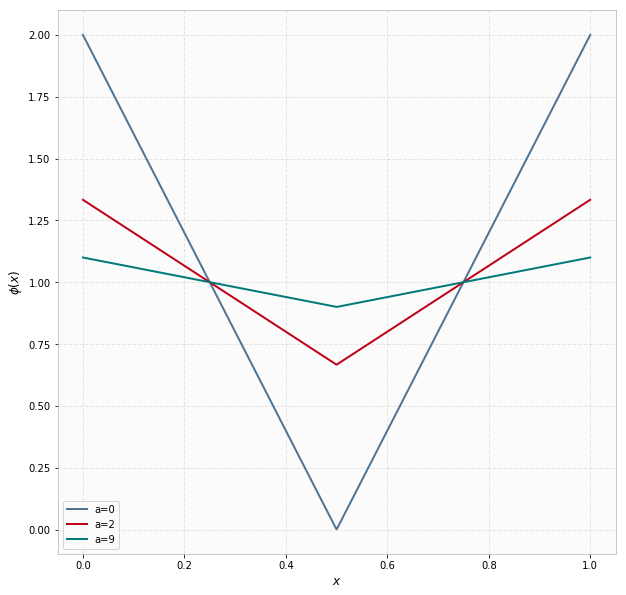

In [5]:
def phi_i(x, a):
    return (np.abs(4*x-2)+a)/(1+a)


plt.figure(figsize=(10, 10))
x = np.linspace(0, 1, 2**10)
for a in [0, 2, 9]:
    plt.plot(x, phi_i(x, a), label='a={}'.format(a))
plt.xlabel('$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend();

To calculate the indices, note that for any $a$,
$$
\int_0^1\phi_i(x)\,dx=1,
$$
so
$$
f=\prod_{i=1}^d\bigl(1+(\phi_i(x)-1)\bigr).
$$
Opening the brackets in the last product, we obtain
$$
f_0=1,\qquad f_{i_1\cdots i_s}=(\phi_{i_1}(x)-1)\cdots(\phi_{i_s}(x)-1),
$$
and we immediately get $D$'s
$$
D_{i_1\cdots i_s}=D_{i_1}\cdots D_{i_s},
$$
with
$$
D_i=\int_0^1\left(\phi_i(x)-1\right)^2dx=\frac1{3(1+a_i)^2}.
$$

## Calculating Sobol' indices

It is not always possible to obtain indices analytically, in this case numerical methods helps us.

Suppose we split the whole set of indices into two groups and are only interested in sensitivity with respect to one of the groups.
Namely, let $x=(y,z)$, $y\in\mathbb R^s$, $z\in\mathbb R^{d-s}$. We get a decomposition
$$
f(x)=f_0+f_1(y)+f_2(z)+f_{12}(y,z),
$$
where
$$
f_1(y)=\int_0^1\cdots \int_0^1f(z)\,dz
\qquad
f_2(z)=\int_0^1\cdots \int_0^1f(y)\,dy,
$$
$$
f_{12}(y,z)=f(x)-f_0-f_1(y)-f_2(z).
$$

The corresponding variances
$$
D=\int_{\mathcal K}f^2(x)\,dx-f_0^2,
$$
$$
D_1=
\int_0^1\cdots\int_0^1f_1^2(y)\,dy=
\int_0^1\cdots\int_0^1\biggl(\int_0^1\cdots\int_0^1f(x)\,dz\biggr)^2\,dy-f^2_0=
$$
$$
\int_0^1\cdots\int_0^1f(y,z)f(y,v)\,dz\,dv\,dy-f_0^2.
$$

The last integrals are multidimensional and can calculated with use of Monte-Carlo method.

## PC-based Sobol' indeces

If we somehow obtained an approximate expansion in polynomials of the function $f$,
then we can immediately get the values of main effect sensitivity indices.

Consider an expansion with respect to an orthogonal multivariate basis $\{P_i\}$
$$
f(x)\approx f_N(x)=\sum_{\alpha\in\mathcal L}c_\alpha P_\alpha(x),
$$
where any $\alpha\in\mathcal L$, $\alpha\subset\mathbb N_0^d$ is 
a set of indices determined by some truncation scheme, for example, hyperbolic.


Then for $f_N$ we have
$$
S_i=\frac
{\sum_{\alpha\in\mathcal L_i}c^2_\alpha\, \mathbb E[P^2_\alpha(x)]}
{\sum_{\alpha\in\mathcal L_*}c^2_\alpha\, \mathbb E[P^2_\alpha(x)]},
$$
where $\mathcal L_*=\mathcal L\setminus\{\mathbf 0\}$,
and $\mathcal L_i\subset\mathcal L$ are set of multiindeces with only one non-zero element in the $\text{i}^{th}$ position
$$
\{0,0,\ldots,0,a_i,0,\ldots,0\}\in\mathcal L_i,
\qquad a_i>0.
$$

In the case, when polynomials are not only orthogonal, but also normalized,
$$
\mathbb E[P^2_\alpha(x)]=1,
$$
the formula becomes very simple
$$
S_i=\frac
{\sum_{\alpha\in\mathcal L_i}c^2_\alpha}
{\sum_{\alpha\in\mathcal L_*}c^2_\alpha}
$$

Expanding this process, we can determine two-index coefficients
$$
S_{ij}=\frac
{\sum_{\alpha\in\mathcal L_{ij}}c^2_\alpha}
{\sum_{\alpha\in\mathcal L_*}c^2_\alpha}
$$
with
$$
\{0,0,\ldots,0,a_i,0,\ldots,0,a_j,0,\ldots,0\}\in\mathcal L_{ij},
\qquad a_i>0, \;\; a_j>0.
$$

And so on.

Note, that we can use this formulas in the case not only uniform distribution.

## Numerical examples

Now we will show some examples of calculating the Sobol' indices and comparing them with the exact values in cases where the latter are known.

We take LHS points as node points, and we take twice as many points as the number of basis functions,
thus, we solve the problem by least squares with a margin.

Note that even in this case, the result can vary from run to run
due to the stochastic nature of the LHS generating algorithm.
For the same reason, for symmetric functions symmetry of indices may not be observed.

We begin with a function consisting of products of linear monomials
$$
f=\frac{(2x_1+1)(2x_2+1)\cdots(2x_d+1)}{2^d}.
$$
for which the expansion in polynomials is exact starting from the corresponding number of basis functions.

We take $d=4$ input variables, therefore we expect the numerical calculation to coincide with the theory when the maximal degree of the polynomial equals to $4$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit
from ipywidgets import interact, widgets, fixed
import itertools
from numpy.polynomial import Legendre
from functools import reduce
from pyDOE import lhs
from itertools import combinations


def indices_K(d, N, r=1.0):
    """
    returns all vectors of length l with sum of indices in power p <= q^p, starting form 0
    x^p + y^p <= N^p
    Elements can repeat!
    """
    qp = N**r
    for cmb in itertools.product(range(N+1), repeat=d):
        if sum(np.array(cmb)**r) <= qp:
            yield cmb


def indices_K_cut(d, N, r=1.0, maxn=None):
    a = indices_K(d, N, r)
    a = sorted(a, reverse=True)
    a = [el for el, _ in itertools.groupby(a)]  # delete duplicates
    a = sorted(a, key=lambda e: max(e))
    a = sorted(a, key=lambda e: np.sum(np.array(e)**r))
    if maxn is not None:
        a = a[:maxn]
    return a


def p_legendre(x, n, interval=(0.0, 1.0), to_norm=True):
    """
    Non-normed or normed Legendre poly.
    x is from interval [0, 1] and then it is scaled
    """
    xn = (interval[0] + interval[1] - 2.0*x)/(interval[0] - interval[1])
    res = Legendre.basis(n)(xn)
    if to_norm:
        res /= np.sqrt(p_legendre_snorm(n, interval=interval))
    return res


def p_legendre_snorm(n, interval=(-1.0, 1.0)):
    """
    RETURNS E[L_n L_n]
    """
    return (interval[1] - interval[0])/(2.0*n + 1.0)


def p_trvial(x, n):
    return x**n


def system_mat_multi(max_pow, x, poly=p_legendre, r=1.0):
    """
    Multivariate system matrix based on given polys and points.
    INPUT
    max_pow -- maximum polynimial power
    x -- points (nodes)
    r -- parameter is hyperbolic truncation scheme

    OUTPUT
    A -- matrix
    """
    N_x, d = x.shape
    indices = indices_K_cut(d, max_pow, r)
    A = np.empty((N_x, len(indices)))
    for i, xp in enumerate(indices):
        A[:, i] = np.prod([poly(x[:, j], xp[j]) for j in range(d)], axis=0)

    return A


def indices_L(indices, subscript):
    indices = np.array(indices, copy=False)
    subscript = np.array(subscript, copy=False)
    all_idx = np.arange(indices.shape[1], dtype=int)
    other_idx = np.setdiff1d(all_idx, subscript)

    def filter_func(x):
        return (x[subscript] != 0).all() and (x[other_idx] == 0).all()

    return np.array([i for i, x in enumerate(indices) if filter_func(x)])


def gPC(func, dim, max_pow, expand_coeff=2.0, poly=p_legendre, r=1.0):
    """
    expand_coeff -- how many points to take
    """
    indices = indices_K_cut(dim, max_pow, r)
    N_x = int(round(len(indices)*expand_coeff))
    X = lhs(dim, samples=N_x, criterion='c')
    A = system_mat_multi(max_pow, X, poly=poly, r=r)
    rhs = np.array([func(*x) for x in X])
    return np.linalg.lstsq(A, rhs, rcond=-1)[0]


def all_subsets(n):
    res = []
    take_from = tuple(np.arange(n, dtype=int))
    for i in range(n):
        res.extend(combinations(take_from, i))

    res.append(take_from)
    return res[1:]


def Sobol_indices(indices, coeffs):
    indices = np.array(indices, copy=False)
    assert np.all(indices[0] == 0), 'indices ordering is wrong'
    D = np.sum(coeffs[1:]**2)
    subsets = all_subsets(indices.shape[1])
    Ds = np.empty(len(subsets))
    for i, s in enumerate(subsets):
        Ds[i] = np.sum([coeffs[j]**2 for j in indices_L(indices, s)])

    return Ds/D


def Sobol_indx_many_powers(func, dim, powers, poly=p_legendre, expand_coeff=2.0):
    res = []
    for i, max_pow in enumerate(powers):
        coeffs = gPC(func, dim=dim, max_pow=max_pow, poly=poly, expand_coeff=expand_coeff)
        S = Sobol_indices(indices_K_cut(dim, max_pow), coeffs)
        res.append(S)

    return np.array(res)


def str_subset(dim, idx_subset):
    subset = all_subsets(dim)[idx_subset]
    return ''.join([str(i+1) for i in subset])


def plot_Sobol(func, dim, powers, S, idx_subset=0, poly=p_legendre, tru_Sobol=None, func_name=''):
    # S = Sobol_indx_many_powers(func, dim, powers=powers, poly=poly)
    plt.figure(figsize=(12, 7))
    plt.plot(powers, S[:, idx_subset], label='Calculated indices')
    if tru_Sobol is not None:
        plt.plot(powers, [tru_Sobol[idx_subset]] *
                 len(powers), label='True indices')
    plt.legend()
    plt.xlabel('Maximum power of polynomial')
    str_S = '$S_{' + str_subset(dim, idx_subset) + '}$'
    plt.ylabel(str_S)
    plt.title('Sobol index ' + str_S + ' for function ' + func_name)


to_check_norm = False
if to_check_norm:
    from scipy.integrate import quad
    print(quad(lambda x: p_legendre(x, 5)*p_legendre(x, 5), -1, 1))

to_check_gPC = False
if to_check_gPC:
    def func(x, y):
        return x**3 + y**2 + x*y
    print(gPC(func, 2, 5, poly=p_trvial))

    def func(x, y):
        return p_legendre(x, 3) + p_legendre(y, 2) + p_legendre(x, 1)*p_legendre(y, 1)
    print(gPC(func, 2, 5, poly=p_legendre))

In [7]:
def linear_based_func(*x):
    return reduce(np.multiply, [xi + 0.5 for xi in x])

def true_linear_based_sobol_indices(dim):
    Di = np.full(dim, 1.0/12.0)
    subsets = all_subsets(dim)
    Ds = np.empty(len(subsets))
    for i, s in enumerate(subsets):
        Ds[i] = np.prod(Di[list(s)])
        
    return Ds/Ds.sum()

dim = 4
powers = range(1, 10)
S = Sobol_indx_many_powers(linear_based_func, dim, powers=powers)
tru_S = true_linear_based_sobol_indices(dim)

In [8]:
opts = {r'S_' + str_subset(dim, i) + '' : i for i in range(10) }
interact(lambda x : plot_Sobol(linear_based_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_S, func_name='with linear monomials in 4D'),
         x=widgets.RadioButtons(options=opts,description='Sobol\' Index',orientation='horizontal'));

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_3': 2, 'S_4': 3, 'S_12': 4, 'S_13': 5, 'S_14': 6, 'S_23': 7, 'S_24': 8, 'S_34': 9}, value=0), Output()), _dom_classes=('widget-interact',))

Now let us consider a function consisting of the product of quadratic monomials.
$$\def\mon#1{(3x^2_#1+1)}
f=\frac{\mon1\mon2\cdots\mon d}{2^d}.
$$

We also take $d=4$, but now the total degree of this polynomial is greater.

In [9]:
def quad_based_func(*x):
    return reduce(np.multiply, [1.5*xi*xi + 0.5 for xi in x])


def true_quad_based_sobol_indices(dim):
    Di = np.full(dim, 1.0/5.0)
    subsets = all_subsets(dim)
    Ds = np.empty(len(subsets))
    for i, s in enumerate(subsets):
        Ds[i] = np.prod(Di[list(s)])

    return Ds/Ds.sum()


dim = 4
powers = range(1, 10)
S = Sobol_indx_many_powers(quad_based_func, dim, powers=powers)
tru_S = true_quad_based_sobol_indices(dim)

In [10]:
opts = {'S_' + str_subset(dim, i) + '': i for i in [0, 1, 4, 5, 9, 12, 14]}
interact(lambda x: plot_Sobol(quad_based_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_S, func_name='with quadratic monomials in 4D'),
         x=widgets.RadioButtons(options=opts, description='Sobol\' Index', orientation='horizontal'));

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_12': 4, 'S_13': 5, 'S_34': 9, 'S_134': 12, 'S_1234': 14}, value=0), Output()), _dom_classes=('widget-interact',))

Now we consider a more complicated example with Sobol' function


We will consider two cases $d=2$ with $a=\{0,9\}$ and $d=3$  with $a=\{0, 2, 9\}$, but now  the maximum power on the plot will be grater in both cases than on the previous examples.

In [11]:
def sobol_func_gen(al):
    def sobol_func(*x):
        return reduce(np.multiply, [phi_i(xi, a) for xi, a in zip(x, al)])
    
    return sobol_func

def true_sobol_sobol_indices(a):
    a = np.array(a)
    Di = 1.0/(3.0*(1.0+a)**2)
    subsets = all_subsets(len(Di))
    Ds = np.empty(len(subsets))
    for i, s in enumerate(subsets):
        Ds[i] = np.prod(Di[list(s)])
        
    return Ds/Ds.sum()

a = [0, 9]
dim = len(a)
s_func = sobol_func_gen(a)
powers = [1, 2, 3, 4, 5, 7, 9, 12, 15, 20]
S = Sobol_indx_many_powers(s_func, dim, powers=powers)
tru_S = true_sobol_sobol_indices(a)

In [12]:
opts = {'S_' + str_subset(dim, i) + '' : i for i in range(3) }
interact(lambda x : plot_Sobol(s_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_S, func_name='Sobol in 2D'),
         x=widgets.RadioButtons(options=opts,description='Sobol\' Index',orientation='horizontal')
        );

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_12': 2}, value=0), Output()), _dom_classes=('widget-interact',))

In [13]:
a = [0, 2, 9]
dim = len(a)
s_func = sobol_func_gen(a)
powers = [1, 2, 3, 4, 5, 7, 9, 12, 15, 20]
S = Sobol_indx_many_powers(s_func, dim, powers=powers)
tru_S = true_sobol_sobol_indices(a)

In [14]:
opts = {'S_' + str_subset(dim, i) + '' : i for i in range(7) }
interact(lambda x : plot_Sobol(s_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_S, func_name='Sobol in 3D'),
         x=widgets.RadioButtons(options=opts,description='Sobol\' Index',orientation='horizontal')
        );

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_3': 2, 'S_12': 3, 'S_13': 4, 'S_23': 5, 'S_123': 6}, value=0), Output()), _dom_classes=('widget-interact',))

We see that some indices diverge with the growth of the maximum degree (This happens in most, but not at every run!) . This is due to rounding errors and insufficient information about the function —  we approximate the function by points, and do not seek for the best polynomial approximation.

But let's take more points when solving for the coefficients of gPC expansion using the least-squares method.
Now we take eight times as many points as monomials.

In [15]:
a = [0, 2, 9]
dim = len(a)
s_func = sobol_func_gen(a)
powers = [1, 2, 3, 4, 5, 7, 9, 12, 15, 20]
S = Sobol_indx_many_powers(s_func, dim, powers=powers, expand_coeff=8)
tru_S = true_sobol_sobol_indices(a)

In [16]:
opts = {'S_' + str_subset(dim, i) + '' : i for i in range(7) }
interact(lambda x : plot_Sobol(s_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_S, func_name='Sobol in 3D'),
         x=widgets.RadioButtons(options=opts,description='Sobol\' Index',orientation='horizontal'));

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_3': 2, 'S_12': 3, 'S_13': 4, 'S_23': 5, 'S_123': 6}, value=0), Output()), _dom_classes=('widget-interact',))

Now we see that there is no discrepancy in the growth of the degree. The coincidence with the theoretical value is almost complete, we can conclude what input parameters affect more and which ones — less.

Let us consider the so-called Ishigami function
$$
f=\sin x_1+a\sin^2x_2+x_3^4\sin x_1,
$$
which is widely used to test sensitivity methods.

The indices for this function are known (see the [paper](https://www.researchgate.net/publication/222526449_Global_sensitivity_analysis_using_polynomial_chaos_expansion))
$$
D=\frac{a^2}8+\frac{b\pi^4}5+\frac{b^2\pi^8}{18}+\frac12,
$$
$$
D_1=\frac{b\pi^4}5+\frac{b^2\pi^8}{50}+\frac12,
\qquad
D_2=\frac{a^2}8,
\qquad
D_{13}=\frac{8b^2\pi^8}{225},
$$
and the rest are zero.

In this function, the input parameters are distributed uniformly on the interval $(-\pi,\,\pi)$, so we rescale them.

In [17]:
def ishigami_func_gen(a, b):
    def scale(x):
        return np.pi*(2.0*x-1.0)
    def ishigami_func(x1, x2, x3):
        x1, x2, x3 = scale(np.array([x1, x2, x3]))
        return np.sin(x1) + a*(np.sin(x2)**2) + b*(x3**4)*np.sin(x1)

    return ishigami_func


def true_ishigami_sobol_indices(a, b):
    Ds = np.zeros(7)
    Ds[0] = b*(np.pi**4)*0.2 + b*b*(np.pi**8)*0.02 + 0.5
    Ds[1] = a*a*0.125
    Ds[4] = b*b*(np.pi**8)*8.0/225.0

    return Ds/Ds.sum()

In [18]:
a, b = 7, 0.1
dim = 3
i_func = ishigami_func_gen(a, b)
powers = [1, 2, 3, 4, 5, 7, 9, 12, 15]
S = Sobol_indx_many_powers(i_func, dim, powers=powers)
tru_I = true_ishigami_sobol_indices(a, b)

In [19]:
opts = {'S_' + str_subset(dim, i) + '': i for i in range(7)}
interact(lambda x : plot_Sobol(i_func, dim, powers, S, idx_subset=x, tru_Sobol=tru_I, func_name='Ishigami'),
         x=widgets.RadioButtons(options=opts,description='Sobol\' Index',orientation='horizontal'));

interactive(children=(RadioButtons(description="Sobol' Index", options={'S_1': 0, 'S_2': 1, 'S_3': 2, 'S_12': 3, 'S_13': 4, 'S_23': 5, 'S_123': 6}, value=0), Output()), _dom_classes=('widget-interact',))